<a href="https://colab.research.google.com/github/shah-zeb-naveed/data-science-notes/blob/main/interview_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cache

In [ ]:
%%writefile lru_cache.py
import sys
import requests
from collections import OrderedDict

class ImageCache:
    def __init__(self, max_size_bytes):
        self.max_size = max_size_bytes
        self.cache = OrderedDict()
        self.current_size = 0

    def get(self, url):
        if url in self.cache:
            # Move to end to mark as recently used
            self.cache.move_to_end(url)
            return f"Cache Hit: {url}"
        else:
            try:
                response = requests.get(url)
                response.raise_for_status()
                image_bytes = response.content
                image_size = len(image_bytes)

                # If image is too big to cache, skip caching
                if image_size > self.max_size:
                    return f"Too big. Downloaded (Not Cached): {url}"

                # Evict least recently used items until there's space
                while self.current_size + image_size > self.max_size and self.cache:
                    _, old_bytes = self.cache.popitem(last=False) # first added
                    self.current_size -= len(old_bytes)

                self.cache[url] = image_bytes
                self.current_size += image_size
                return f"Downloaded and Cached: {url}"
            except requests.exceptions.RequestException as e:
                return f"Error downloading image: {e}"

def main():
    if len(sys.argv) < 2:
        print("Usage: python script.py <input_file>")
        sys.exit(1)

    # read fome file
    # input_file = sys.argv[1]
    # with open(input_file, 'r') as f:
    #     lines = f.read().splitlines()

    # max_size = int(lines[0])
    # num_urls = int(lines[1])
    # urls = lines[2:]

    # read from command line
    max_size = int(sys.argv[1])
    num_urls = int(sys.argv[2])
    urls = sys.argv[3:]

    cache = ImageCache(max_size)

    for url in urls:
        result = cache.get(url)
        print(result)

if __name__ == "__main__":
    main()

Overwriting lru_cache.py


In [ ]:
!python lru_cache.py 10000 3 https://placehold.co/600x400.png https://placehold.co/600x400.png https://placehold.co/600x400.png

Downloaded and Cached: https://placehold.co/600x400.png
Cache Hit: https://placehold.co/600x400.png
Cache Hit: https://placehold.co/600x400.png


In [ ]:
min({2:'A',1:'B'})

1

In [ ]:
%%writefile advanced_lru_cache.py
import os
import sys
import requests
#import threading
import time
import pickle
from collections import OrderedDict, defaultdict, deque
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image
from heapq import heappush, heappop



class CacheItem:
    def __init__(self, url, content, size, timestamp, priority=0):
        self.url = url
        self.content = content
        self.size = size
        self.last_access = timestamp
        self.access_count = 1
        self.insert_time = timestamp
        self.priority = priority
        self.ttl_expiry = timestamp + 300  # default TTL of 5 minutes
        self.lfu_heap = []  # minheap for LFU
        self.fifo_queue = deque()  # for FIFO


class ImageCache:
    def __init__(self, max_size_bytes, eviction_policy="FIFO", max_item_size=10_000_000, bandwidth_limit=5, snapshot_file="cache_snapshot.pkl"):
        self.max_size = max_size_bytes
        self.max_item_size = max_item_size

        self.size = 0
#        self.lock = threading.RLock()
        self.eviction_policy = eviction_policy

        self.bandwidth_limit = bandwidth_limit  # max downloads per minute
        self.snapshot_file = snapshot_file

        self.cache = OrderedDict()
        self.download_timestamps = deque()
        self.load_snapshot()

    def save_snapshot(self):
        with open(self.snapshot_file, 'wb') as f:
            pickle.dump(self.cache, f)

    def load_snapshot(self):
        if os.path.exists(self.snapshot_file):
            with open(self.snapshot_file, 'rb') as f:
                self.cache = pickle.load(f)
                self.size = sum(item.size for item in self.cache.values())

    def _evict(self):

        # optimization
        if self.eviction_policy == "LFU":
            while self.lfu_heap:
                # insert_time not used but can be used for breaking ties
                access_count_at_push, _, url = heappop(self.lfu_heap)
                if url in self.cache:
                    item = self.cache[url]
                    # not stale if access_counts match
                    if item.access_count == access_count_at_push:
                        del self.cache[url]
                        self.size -= item.size
                        break  # valid eviction

        # practically, this is the same as ordereddict I think
        elif self.eviction_policy == "FIFO":
            while self.fifo_queue:
                url = self.fifo_queue.popleft()
                # evicted URLs can stay in queue so check this
                if url in self.cache:
                    item = self.cache.pop(url)
                    self.size -= item.size
                    break  # evicted

        if self.eviction_policy == "LRU":
            url, item = self.cache.popitem(last=False)
        elif self.eviction_policy == "FIFO":
            url = next(iter(self.cache))
            item = self.cache.pop(url)
        elif self.eviction_policy == "LFU":
            url = min(self.cache, key=lambda k: self.cache[k].access_count)
            item = self.cache.pop(url)

        elif self.eviction_policy == "PRIORITY":
            url = min(self.cache, key=lambda k: self.cache[k].priority)
            item = self.cache.pop(url)
        else:
            # default
            url, item = self.cache.popitem(last=False)

        self.size -= item.size

    def _is_bandwidth_limited(self):
        now = time.time()
        # remove timestamps older than 1 minute
        if self.download_timestamps:
          diff  = now - self.download_timestamps[0]
          #print('diff:', diff)

        # bandiwth measured per minute so remove any old before calculating numerator
        while self.download_timestamps and now - self.download_timestamps[0] > 60:
            self.download_timestamps.popleft()

        requests_per_minute = len(self.download_timestamps) + 1 # this current
        print('requests_per_minute:', requests_per_minute)
        return requests_per_minute > self.bandwidth_limit

    def _download(self, url):
        if self._is_bandwidth_limited():
            raise Exception(f"Bandwidth limit exceeded. Try again later.")

        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()
            content = response.content
            if len(content) > self.max_item_size:
                return f"Image too large to cache: {url}"
            self.download_timestamps.append(time.time())
            return content
        except requests.exceptions.RequestException as e:
            return f"Error downloading image: {e}"

    def get(self, url):
        #with self.lock:
          now = time.time()

          # Clean expired items
          # Eviction is a separate process than this
          expired = [key for key, item in self.cache.items() if now > item.ttl_expiry]
          for key in expired:
              self.size -= self.cache[key].size
              del self.cache[key]

          if url in self.cache:
              item = self.cache[url]
              item.last_access = now
              item.access_count += 1
              # Only move to end if we're using LRU policy
              if self.eviction_policy == "LRU":
                  self.cache.move_to_end(url)

              # Also inside get(), after item.access_count += 1, if LFU, push updated count
              if self.eviction_policy == "LFU":
                  heappush(self.lfu_heap, (item.access_count, item.insert_time, url))

              return f"CACHE HIT: {url}"

          result = self._download(url)

          image_size = len(result)
          if image_size > self.max_size:
              return f"Image exceeds total cache size: {url}"

          while self.size + image_size > self.max_size:
              self._evict()

          new_item = CacheItem(url, result, image_size, now)
          self.cache[url] = new_item
          self.size += image_size

          # optimizaiton
          if self.eviction_policy == "LFU":
              heappush(self.lfu_heap, (new_item.access_count + 1, new_item.insert_time, url))
          elif self.eviction_policy == "FIFO":
              self.fifo_queue.append(url)

          return f"DOWNLOADED: {url}"

    def prefetch(self, urls):
        for url in urls:
            #threading.Thread(target=self.get, args=(url,)).start()
            self.get(url)

if __name__ == "__main__":
    if len(sys.argv) != 2:
        print("Usage: python image_cache.py <input_file>")
        sys.exit(1)

    input_file = sys.argv[1]

    with open(input_file, 'r') as f:
        max_cache_size = int(f.readline().strip())
        n = int(f.readline().strip())
        urls = [f.readline().strip() for _ in range(n)]

    cache = ImageCache(max_cache_size, eviction_policy="FIFO")
    for url in urls:
        print('---')
        print(url)
        result = cache.get(url)
        print(result)
        #time.sleep(5)

    cache.get("https://placehold.co/600x400/EEE/31343C?font=poppins&text=Poppins")

    print('===')
    # Example of prefetching (next likely images)
    #cache.prefetch(["https://placehold.co/600x400/EEE/31343C?font=poppins&text=Poppins"])

    # Save snapshot at the end
    #cache.save_snapshot()

Overwriting advanced_lru_cache.py


In [ ]:
%%writefile input.txt
10000
3
https://placehold.co/600x400.png
https://placehold.co/600x400.png
https://placehold.co/150x150.png

Overwriting input.txt


In [ ]:
!python advanced_lru_cache.py input.txt

---
https://placehold.co/600x400.png
requests_per_minute: 1
DOWNLOADED: https://placehold.co/600x400.png
---
https://placehold.co/600x400.png
CACHE HIT: https://placehold.co/600x400.png
---
https://placehold.co/150x150.png
requests_per_minute: 2
DOWNLOADED: https://placehold.co/150x150.png
requests_per_minute: 3
===


| Feature                   | Heap-Based LFU                     | `min()` on `OrderedDict` LFU              |
| ------------------------- | ---------------------------------- | ----------------------------------------- |
| **Eviction Time**         | **O(log n)** (heap push/pop)       | **O(n)** (`min()` over all items)         |
| **Access Time (get/put)** | O(1) + heap push = O(log n)        | O(1) + O(1) update + O(n) min at eviction |
| **Space Overhead**        | O(n) for `cache`, O(n) for `heap`  | O(n) for `cache` only                     |
| **Pros**                  | Fast eviction                      | Simpler implementation                    |
| **Cons**                  | More memory and stale heap entries | Slower eviction due to full scan          |


| Feature            | Deque-Based FIFO                    | `OrderedDict` FIFO                 |
| ------------------ | ----------------------------------- | ---------------------------------- |
| **Eviction Time**  | O(1) with stale-check (amortized)   | **O(1)** via `popitem(last=False)` |
| **Access Time**    | O(1) + stale cleanup                | **O(1)**                           |
| **Space Overhead** | O(n) for `cache` + O(n) for `deque` | O(n) for single `OrderedDict`      |
| **Pros**           | Explicit queue logic, flexible      | Cleanest and most efficient        |
| **Cons**           | Potential stale entries             | Less customizable                  |


| Policy   | Best for Performance | Best for Simplicity |
| -------- | -------------------- | ------------------- |
| **LFU**  | Heap-based           | `min()` + `dict`    |
| **FIFO** | `OrderedDict`        | `OrderedDict`       |


| **Strategy**                         | **Pros**                                                                 | **Cons**                                                       | **Use Cases**                                                                    |
| ------------------------------------ | ------------------------------------------------------------------------ | -------------------------------------------------------------- | -------------------------------------------------------------------------------- |
| **LRU (Least Recently Used)**        | Simple and efficient eviction of least recently accessed items           | Poor for workloads with frequent full scans or cyclic patterns | Browser caches, database buffers, in-memory caches (e.g., `functools.lru_cache`) |
| **LFU (Least Frequently Used)**      | Retains hot items accessed repeatedly, good for skewed access patterns   | Requires frequency tracking; may retain stale "popular" items  | CDN edge caches, recommendation systems                                          |
| **FIFO (First In First Out)**        | Simple and predictable                                                   | Ignores access pattern; may evict useful items                 | Streaming data, write-behind caches                                              |
| **Random Replacement**               | Low-overhead eviction                                                    | Non-deterministic; can evict hot items                         | Hardware caches (e.g., CPU), when memory is tight                                |
| **TTL (Time to Live)**               | Auto-purges stale items after a time threshold                           | Fixed expiration may evict still-useful items                  | DNS caching, session tokens                                                      |
| **ARC (Adaptive Replacement Cache)** | Balances between LRU and LFU adaptively                                  | Complex to implement                                           | Filesystem page caching (ZFS, IBM DB2)                                           |
| **MRU (Most Recently Used)**         | Good for patterns where recently used items are less likely to be reused | Counterintuitive for many apps; rarely used alone              | Specific DB workloads (e.g., full table scans), specialized memory pools         |
| **2Q Cache**                         | Improves LRU by filtering out short-lived entries                        | Slightly more complex than LRU                                 | Web servers, virtual memory systems                                              |
| **Segmented LRU**                    | Prevents cache pollution from one workload segment                       | Needs workload classification                                  | JVM memory pools, multi-tenant environments                                      |


# In-Memory DB

In [ ]:
%%writefile mem_db.py

from sortedcontainers import SortedDict
from typing import Any, Optional
import time

class InMemoryDatabase:
    def __init__(self):
        # Primary key-value store
        self.store = dict()

        # Secondary index: sorted by key
        self.sorted_keys = SortedDict()

        # Timestamp index: maps timestamp -> key
        self.timestamp_index = SortedDict()

    def put(self, key: Any, value: Any, timestamp: Optional[float] = None):
        """Insert or update a key with value and optional timestamp."""
        self.store[key] = value
        self.sorted_keys[key] = value

        ts = timestamp if timestamp is not None else time.time()
        self.timestamp_index[ts] = key

    def get(self, key: Any) -> Optional[Any]:
        """Get value for a key."""
        return self.store.get(key)

    def delete(self, key: Any):
        """Delete key from database."""
        if key in self.store:
            del self.store[key]
        if key in self.sorted_keys:
            del self.sorted_keys[key]

        # Remove from timestamp index
        to_remove = [ts for ts, k in self.timestamp_index.items() if k == key]
        for ts in to_remove:
            del self.timestamp_index[ts]

    def get_range(self, start_key: Any, end_key: Any) -> dict:
        """Get all key-value pairs within the key range [start_key, end_key)."""
        keys = [k for k in self.sorted_keys.irange(start_key, end_key)]
        return {k: self.store[k] for k in keys}

    def get_by_time_range(self, start_time: float, end_time: float) -> dict:
        """Return key-value pairs inserted in a given time range."""
        result = {}
        for ts in self.timestamp_index.irange(start_time, end_time):
            key = self.timestamp_index[ts]
            if key in self.store:
                result[key] = self.store[key]
        return result

    def dump(self) -> dict:
        """Return all key-value pairs."""
        return dict(self.store)

# Example usage
if __name__ == "__main__":
    db = InMemoryDatabase()
    db.put("a", 1)
    time.sleep(0.1)
    db.put("b", 2)
    time.sleep(0.1)
    db.put("c", 3)
    time.sleep(1)
    db.put("d", 5)

    print("Get b:", db.get("b"))
    print("Range a to c:", db.get_range("a", "c"))

    print("Time range:", db.get_by_time_range(time.time() - 1, time.time()))
    db.delete("b")
    print("After delete b:", db.dump())


Overwriting mem_db.py


In [ ]:
!python mem_db.py

Get b: 2
Range a to c: {'a': 1, 'b': 2, 'c': 3}
Time range: {'d': 5}
After delete b: {'a': 1, 'c': 3, 'd': 5}


In [ ]:
# without sortedcontainer, using bisect. bisect insert is still O(n)
# unlike sortedcontainers which used a balanced tree data structure

import bisect

class ManualSortedDict:
    def __init__(self):
        self.store = {}

        # extra list that's always maintained sorted
        self.sorted_keys = []

    def put(self, key, value):
        if key not in self.store:
            bisect.insort(self.sorted_keys, key)
        self.store[key] = value

    def get(self, key):
        return self.store.get(key)

    def delete(self, key):
        if key in self.store:
            self.sorted_keys.remove(key)
            del self.store[key]

    def get_range(self, start, end):
        start_idx = bisect.bisect_left(self.sorted_keys, start)
        end_idx = bisect.bisect_left(self.sorted_keys, end)
        return {
            k: self.store[k]
            for k in self.sorted_keys[start_idx:end_idx]
        }


In [ ]:
class ManualSortedDict:
    def __init__(self):
        self.store = {}
        self.sorted_keys = []
        self.sorted_timestamps = []  # list of (timestamp, key) tuples

    def insert_sorted(self, key):
        low, high = 0, len(self.sorted_keys)
        while low < high:
            mid = (low + high) // 2
            if self.sorted_keys[mid] < key:
                low = mid + 1 # definitely not the right place
            else:
                high = mid
        self.sorted_keys.insert(low, key)

    def insert_sorted_timestamp(self, timestamp, key):
        low, high = 0, len(self.sorted_timestamps)
        while low < high:
            mid = (low + high) // 2
            if self.sorted_timestamps[mid][0] < timestamp:
                low = mid + 1
            else:
                high = mid
        self.sorted_timestamps.insert(low, (timestamp, key))

    def put(self, key, value, timestamp):
        if key not in self.store:
            self.insert_sorted(key)
            self.insert_sorted_timestamp(timestamp, key)
        else:
            # remove old timestamp entry and insert new one
            old_ts, _ = self.store[key]
            self.sorted_timestamps.remove((old_ts, key))
            self.insert_sorted_timestamp(timestamp, key)
        self.store[key] = (timestamp, value)

    def get(self, key):
        item = self.store.get(key)
        return item[1] if item else None

    def delete(self, key):
        if key in self.store:
            self.sorted_keys.remove(key)
            ts, _ = self.store[key]
            self.sorted_timestamps.remove((ts, key))
            del self.store[key]

    def get_range(self, start, end):
        start_idx = self.binary_search(self.sorted_keys, start)
        end_idx = self.binary_search(self.sorted_keys, end)
        return {
            k: self.store[k][1]
            for k in self.sorted_keys[start_idx:end_idx]
        }

    def get_range_by_time(self, start_ts, end_ts):
        start_idx = self.binary_search_ts(start_ts)
        end_idx = self.binary_search_ts(end_ts)
        keys_in_range = [k for ts, k in self.sorted_timestamps[start_idx:end_idx]]
        return {
            k: self.store[k][1] for k in keys_in_range
        }

    def binary_search(self, arr, key):
        low, high = 0, len(arr)
        while low < high:
            mid = (low + high) // 2
            if arr[mid] < key:
                low = mid + 1
            else:
                high = mid
        return low

    def binary_search_ts(self, timestamp):
        low, high = 0, len(self.sorted_timestamps)
        while low < high:
            mid = (low + high) // 2
            if self.sorted_timestamps[mid][0] < timestamp:
                low = mid + 1
            else:
                high = mid
        return low


# Text Processing

For NLP stuff, https://github.com/shah-zeb-naveed/nlp/blob/main/nlp_pre_interview_refresher.ipynb

In [ ]:
%%writefile word_counter.py

import sys
from collections import defaultdict

def word_count(file_path):
    counts = defaultdict(int)
    with open(file_path, 'r') as f:
        for line in f:
            for word in line.strip().split():
                counts[word] += 1

    for word in sorted(counts):
        print(f"{word} {counts[word]}")

if __name__ == "__main__":
    if len(sys.argv) < 2:
        print("Usage: python word_counter.py <input_file>")
        sys.exit(1)

    word_count(sys.argv[1])

Writing word_counter.py


In [ ]:
%%writefile input.txt
apple banana apple
orange apple banana

Writing input.txt


In [ ]:
!python word_counter.py input.txt

apple 3
banana 2
orange 1


# File I/O

In [ ]:
# prompt: create a short snippet that writes into csv file and then reads it back

import csv

def write_and_read_csv(filename, data):
    # Write data to CSV file
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)

def csv_reader(csvfile):
    # Read data from CSV file
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        read_data = list(reader)

    return read_data


# Example usage
data = [
    ["Name", "Age", "City"],
    ["Alice", "25", "New York"],
    ["Bob", "30", "Los Angeles"],
    ["Charlie", "28", "Chicago"]
]

filename = "example.csv"
read_data = write_and_read_csv(filename, data)
print(csv_reader(filename))

[['Name', 'Age', 'City'], ['Alice', '25', 'New York'], ['Bob', '30', 'Los Angeles'], ['Charlie', '28', 'Chicago']]


# Log Processing

In [ ]:
import re
from datetime import datetime
from collections import defaultdict

class LogParser:
    def __init__(self, log_file_path):
        self.log_file_path = log_file_path
        self.entries = []
        self._parse_log()

    def _parse_log(self):
        log_pattern = re.compile(r'(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2})\s+(?P<level>[A-Z]+)\s+(?P<message>.+)')
        with open(self.log_file_path, 'r') as f:
            for line in f:
                match_ = log_pattern.match(line.strip())
                if match_:
                    ts = datetime.strptime(match_.group('timestamp'), "%Y-%m-%d %H:%M:%S")
                    self.entries.append({
                        'timestamp': ts,
                        'level': match_.group('level'),
                        'message': match_.group('message')
                    })

    def filter(self, level=None, keyword=None, start=None, end=None):
        result = self.entries
        if level:
            result = [entry for entry in result if entry['level'] == level]
        if keyword:
            result = [entry for entry in result if keyword in entry['message']]
        if start:
            result = [entry for entry in result if entry['timestamp'] >= start]
        if end:
            result = [entry for entry in result if entry['timestamp'] <= end]
        return result

    def count_errors_per_hour(self):
        hourly_counts = defaultdict(int)
        for entry in self.entries:
            if entry['level'] == 'ERROR':
                hour = entry['timestamp'].replace(minute=0, second=0, microsecond=0)
                hourly_counts[hour] += 1
        return dict(hourly_counts)


In [ ]:
%%writefile server.log
2025-05-11 08:00:01 INFO Starting server on port 8080
2025-05-11 08:01:15 WARN Memory usage is high
2025-05-11 08:15:42 ERROR Failed to connect to database
2025-05-11 08:45:12 INFO Health check passed
2025-05-11 09:03:34 ERROR Timeout while processing request
2025-05-11 09:15:01 INFO User login successful
2025-05-11 10:00:00 ERROR Disk space low on /dev/sda1
2025-05-11 10:05:23 WARN CPU temperature nearing threshold
2025-05-11 10:45:11 INFO Request handled successfully
2025-05-11 11:00:00 INFO Scheduled maintenance started
2025-05-11 11:15:45 ERROR Backup process failed due to permissions

Writing server.log


In [ ]:
# Example usage:
parser = LogParser('server.log')
filtered = parser.filter(level='ERROR', keyword='timeout')
errors_by_hour = parser.count_errors_per_hour()
errors_by_hour

NameError: name 'LogParser' is not defined

# Batch Processing

In [ ]:
import os
import pandas as pd

try:
    from pyspark.sql import SparkSession
    from pyspark.sql.types import *
    import pyspark.sql.functions as F
    SPARK_AVAILABLE = True
except ImportError:
    SPARK_AVAILABLE = False
    print("PySpark is not installed. Batch processing with Spark is not available.")


In [ ]:
%%writefile sample.csv
id,name,age,salary,department
1,Alice,30,70000,Engineering
2,Bob,25,50000,Sales
3,Charlie,35,80000,Engineering
4,David,40,90000,HR
5,Eve,28,55000,Marketing
6,Frank,50,100000,Engineering
7,Grace,22,45000,Sales
8,Hannah,31,75000,Marketing
9,Ian,29,52000,Engineering
10,Jane,38,88000,HR

Writing sample.csv


In [ ]:
x = None
if x is None:
  print('s')

s


In [ ]:
class BatchFileProcessor:
    def __init__(self, filepath, batch_size=1000):
        self.filepath = filepath
        self.batch_size = batch_size
        self.file_type = self._detect_file_type()

    def _detect_file_type(self):
        ext = os.path.splitext(self.filepath)[-1].lower()
        return "csv" if ext == ".csv" else "text"

    def read_text_in_batches(self, filter_fn=None):
        with open(self.filepath, "r", encoding="utf-8") as f:
            batch = []
            for line in f:
                if filter_fn is None or filter_fn(line): # smart
                    batch.append(line.rstrip())
                if len(batch) >= self.batch_size:
                    yield batch
                    batch = []
            if batch:
                yield batch

    def read_csv_in_batches(self, filter_fn=None, usecols=None):
        for chunk in pd.read_csv(self.filepath, chunksize=self.batch_size, usecols=usecols): # , skiprows=1, header=None
            if filter_fn:
                chunk = chunk[chunk.apply(filter_fn, axis=1)]
            yield chunk

    def read_with_spark(self, filter_expr=None, columns=None):
        if not SPARK_AVAILABLE:
            raise ImportError("PySpark is not installed.")

        spark = SparkSession.builder.getOrCreate()
        df = spark.read.csv(self.filepath, header=True, inferSchema=True)
        if columns:
            df = df.select(columns)
        if filter_expr:
            df = df.filter(filter_expr)
        return df

    def process_batches(self, processor_fn, mode="text", **kwargs):
        if mode == "text":
            for batch in self.read_text_in_batches(**kwargs):
                processor_fn(batch)
        elif mode == "csv":
            for batch in self.read_csv_in_batches(**kwargs):
                processor_fn(batch)
                print('---')
        else:
            raise ValueError("Unsupported mode: choose 'text' or 'csv'")

def filter_fn_error(line):
    return "INFO" in line


# custom processor function
def processor_fn(batch):
  if isinstance(batch, pd.DataFrame):
    print(batch.shape)
  else:
    print(batch)

bfp = BatchFileProcessor('server.log', batch_size=2)
bfp.process_batches(processor_fn, mode="text", filter_fn=filter_fn_error)

['2025-05-11 08:00:01 INFO Starting server on port 8080', '2025-05-11 08:45:12 INFO Health check passed']
['2025-05-11 09:15:01 INFO User login successful', '2025-05-11 10:45:11 INFO Request handled successfully']
['2025-05-11 11:00:00 INFO Scheduled maintenance started']


In [ ]:
def filter_fn_age(df):
    return df['salary'] > 50000

bfp = BatchFileProcessor('sample.csv', batch_size=2)
bfp.process_batches(processor_fn, mode="csv", filter_fn=filter_fn_age)

(1, 5)
---
(2, 5)
---
(2, 5)
---
(1, 5)
---
(2, 5)
---


In [ ]:
import numpy as np
from sklearn.linear_model import SGDRegressor

# Step 1: Create and save large data to disk (once)
X = np.random.rand(1_000_000, 20)
y = np.random.rand(1_000_000)

np.save('X.npy', X)
np.save('y.npy', y)

# Step 2: Load with memmap for batch processing
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

X_path, y_path = 'X.npy', 'y.npy'
n_samples, n_features = 1_000_000, 20
batch_size = 10000

model = SGDRegressor()
patience, wait = 3, 0
min_val_loss = float('inf')

for epoch in range(50):
    X_mem = np.memmap(X_path, dtype='float32', mode='r', shape=(n_samples, n_features))
    y_mem = np.memmap(y_path, dtype='float32', mode='r', shape=(n_samples,))

    for i in range(0, n_samples, batch_size):
        X_batch = X_mem[i:i + batch_size]
        y_batch = y_mem[i:i + batch_size]
        mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)

        # Filtered arrays
        X_clean = X[mask]
        y_clean = y[mask]

        model.partial_fit(X_clean, y_clean)

    # Validation (assuming X_val, y_val are in memory)
    val_loss = mean_squared_error(y_clean, model.predict(X_clean))
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch}")
            break


Early stopping at epoch 5


# Parallel Computation

| Strategy               | Functionality                                              | Analogy                               | Key Components                                      | Use Cases                                     | Parallelism          | GIL Handling                                       |
| ---------------------- | ---------------------------------------------------------- | ------------------------------------- | --------------------------------------------------- | --------------------------------------------- | -------------------- | -------------------------------------------------- |
| **Threading**          | Runs multiple tasks concurrently, best for I/O-bound tasks | One waiter serving many tables        | `threading.Thread`, `Lock`                          | Web scraping, file I/O, API calls             | No                   | GIL blocks CPU-bound                               |
| **Multiprocessing**    | Runs tasks in separate processes, true parallelism         | Multiple chefs in separate kitchens   | `multiprocessing.Process`, `Pool`, `Queue`          | CPU-bound work, ML training, video processing | Yes                  | Each process has own GIL                           |
| **Asyncio**            | Cooperative multitasking for I/O-bound tasks               | One chef juggling many timers         | `async def`, `await`, `asyncio.run`, `gather`       | Web servers, DB queries, async APIs           | No (concurrent only) | Single-threaded, GIL not an issue                  |
| **Joblib / Dask**      | High-level parallelism for ML/data                         | Factory line with distributed workers | `joblib.Parallel`, `dask.delayed`, `Dask DataFrame` | Scikit-learn training, big data batch jobs    | Yes                  | Under the hood uses multiprocessing or distributed |
| **Cython/Numba**       | Compiles Python to fast machine code                       | Assembling parts using power tools    | `@jit`, `cdef`, `prange`                            | Numeric computation, loops on arrays          | Yes (with config)    | Can release GIL                                    |
| **Concurrent.futures** | Simplified interface for threads or processes              | Task manager delegating to teams      | `ThreadPoolExecutor`, `ProcessPoolExecutor`         | Async task execution, simple parallelism      | Thread/Process       | Depends on executor type                           |


In [ ]:
start = time.time()

import threading
import time

def io_task():
    time.sleep(2)  # Simulates I/O
    print("Finished I/O")

# Serial
io_task()
io_task()

print("Total time:", time.time() - start)

Finished I/O
Finished I/O
Total time: 4.001073598861694


In [ ]:
start = time.time()
# multiple threads run in the same process.
# Due to GIL, only one thread runs
# releases GIL for other thread and then recaptures


# Parallel with threads
t1 = threading.Thread(target=io_task)
t2 = threading.Thread(target=io_task)
t1.start()
t2.start()
t1.join()
t2.join()

print("Total time:", time.time() - start)

Finished I/O
Finished I/O
Total time: 2.0027577877044678


In [ ]:
from multiprocessing import Process
import time

# separate processes running on different CPU cores
# own python interpretor and mempory space


def task(name):
    print(f"{name} starting")
    time.sleep(2)
    print(f"{name} done")

p1 = Process(target=task, args=("Process-1",))
p2 = Process(target=task, args=("Process-2",))
p1.start()
p2.start()
p1.join()
p2.join()


Process-1 starting
Process-2 starting
Process-1 done
Process-2 done


In [ ]:
import asyncio

# single thread but cooperative
# using await #

async def cook(item, time_sec):
    print(f"Started cooking {item}")
    await asyncio.sleep(time_sec)  # Simulates waiting (non-blocking)
    print(f"Finished cooking {item}")

async def main():
    # Launch all tasks concurrently
    await asyncio.gather(
        cook("Pasta", 3),
        cook("Soup", 2),
        cook("Steak", 4),
    )

#asyncio.run(main())
await main()


Started cooking Pasta
Started cooking Soup
Started cooking Steak
Finished cooking Soup
Finished cooking Pasta
Finished cooking Steak


In [ ]:
import os
import pandas as pd
import threading
import multiprocessing
from queue import Queue

try:
    from pyspark.sql import SparkSession
    SPARK_AVAILABLE = True
except ImportError:
    SPARK_AVAILABLE = False


def character_counter(batch):
    count = 0
    for line in batch:
        for char in line:
            count += 1
    print(f"Processed batch with {count} characters")


class BatchFileProcessor:
    def __init__(self, filepath, batch_size=1000):
        self.filepath = filepath
        self.batch_size = batch_size

    def read_text_in_batches(self, output_queue, filter_fn=None):
        with open(self.filepath, "r", encoding="utf-8") as f:
            batch = []
            for line in f:
                if filter_fn is None or filter_fn(line):
                    batch.append(line.rstrip())
                if len(batch) == self.batch_size:
                    output_queue.put(batch)
                    batch = []
            if batch:
                output_queue.put(batch)
        output_queue.put(None)

    def read_csv_in_batches(self, output_queue, filter_fn=None, usecols=None):
        for chunk in pd.read_csv(self.filepath, chunksize=self.batch_size, usecols=usecols):
            if filter_fn:
                chunk = chunk[chunk.apply(filter_fn, axis=1)]
            lines = chunk.astype(str).values.tolist()
            flat_lines = [" ".join(row) for row in lines]
            output_queue.put(flat_lines)
        output_queue.put(None)

    def read_with_spark(self, filter_expr=None, columns=None):
        if not SPARK_AVAILABLE:
            raise ImportError("PySpark is not installed.")

        spark = SparkSession.builder.getOrCreate()
        df = spark.read.csv(self.filepath, header=True, inferSchema=True)
        if columns:
            df = df.select(columns)
        if filter_expr:
            df = df.filter(filter_expr)
        return df

    def process_batches_with_multiprocessing(self, mode="text", **kwargs):
        output_queue = Queue()

        # define threads
        if mode == "text":
            thread = threading.Thread(target=self.read_text_in_batches, args=(output_queue,), kwargs=kwargs)

        elif mode == 'csv':
            thread = threading.Thread(target=self.read_csv_in_batches, args=(output_queue,), kwargs=kwargs)
        else:
            raise ValueError("Unsupported mode: choose 'text' or 'csv'")

        thread.start()

        pool = multiprocessing.Pool()
        active = 0
        while True:
            batch = output_queue.get()
            if batch is None:
                break
            pool.apply_async(character_counter, args=(batch,))
            active += 1

        thread.join()
        pool.close()
        pool.join()


start_time = time.time()

bfp = BatchFileProcessor('server.log', batch_size=2)
bfp.process_batches_with_multiprocessing(mode="text")

print("Total time:", time.time() - start)

Processed batch with 98 charactersProcessed batch with 99 characters
Processed batch with 104 characters

Processed batch with 107 charactersProcessed batch with 111 characters

Processed batch with 66 characters
Total time: 3196.8767352104187


# Priority Queue

In [ ]:
import heapq
import itertools

class PrioritizedItem:
    def __init__(self, priority, item):
        self.priority = priority
        self.item = item

    def __lt__(self, other):
        return self.priority < other.priority

class CustomPriorityQueue:
    def __init__(self):
        self.heap = []
        self.__entry_finder = {}  # mapping of items to entries
        self.REMOVED = "<removed-task>"
        self.counter = itertools.count()  # unique sequence count # just a counter

    def add(self, item, priority=0):
        # already exists
        if item in self.__entry_finder:
            self.remove(item)


        count = next(self.counter) # just a counter
        entry = [priority, count, item]
        self.__entry_finder[item] = entry
        heapq.heappush(self.heap, entry)

    def remove(self, item):
        # remove from mapper
        entry = self.__entry_finder.pop(item)

        # label it, lazy delete
        entry[-1] = self.REMOVED

    def pop(self):
        while self.heap:
            priority, count, item = heapq.heappop(self.heap)
            if item is not self.REMOVED: # check validity
                del self.__entry_finder[item]
                return item
        raise KeyError("pop from an empty priority queue")

    def peek(self):
        while self.heap:
            priority, count, item = self.heap[0]
            if item is self.REMOVED: # check validity: # item marked as removed
                heapq.heappop(self.heap)
            else:
                return item
        raise KeyError("peek from an empty priority queue")

    def __contains__(self, item):
        return item in self.__entry_finder

    def __len__(self):
        return len(self.__entry_finder)

q = CustomPriorityQueue()
q.add('a', 1)
q.add('b', 2)
q.add('c', 3)
q.add('d', 4)

q.peek()
q.remove('b')
q.pop()
q.peek()
q.remove('c')

print(q._CustomPriorityQueue__entry_finder)
print(q.heap)
q.peek()

{'d': [4, 3, 'd']}
[[3, 2, '<removed-task>'], [4, 3, 'd']]


'd'

In [ ]:
def test_task_scheduler():
    tasks = [
        ("Email Sync", 3),
        ("Video Encoding", 1),
        ("System Backup", 2),
        ("Antivirus Scan", 4),
    ]


    pq = CustomPriorityQueue()
    for task, priority in tasks:
        pq.add(task, priority)

    print("Processing tasks by priority:")
    while len(pq):
        print(pq.pop())

test_task_scheduler()

Processing tasks by priority:
Video Encoding
System Backup
Email Sync
Antivirus Scan


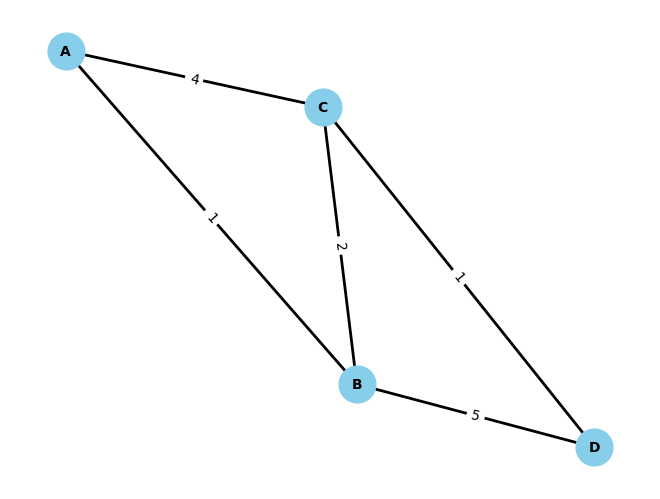

Distance from A to A: 0
Distance from A to B: 1
Distance from A to C: 3
Distance from A to D: 4


In [ ]:
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph(graph_dict):
  graph = nx.Graph()
  for node, edges in graph_dict.items():
    for neighbor, weight in edges:
      graph.add_edge(node, neighbor, weight=weight)

  pos = nx.spring_layout(graph)  # positions for all nodes
  nx.draw(graph, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=10, font_weight='bold', width=2)
  edge_labels = nx.get_edge_attributes(graph,'weight')
  nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
  plt.show()


# add start
def dijkstra(graph, start):
    pq = CustomPriorityQueue()
    distances = {node: float('inf') for node in graph}
    distances[start] = 0
    pq.add(start, 0)

    while len(pq):
        current = pq.pop()

        for neighbor, weight in graph[current]:
            new_dist = distances[current] + weight
            if new_dist < distances[neighbor]:
                distances[neighbor] = new_dist
                pq.add(neighbor, new_dist)

    return distances

def test_dijkstra():
    graph = defaultdict(list)
    graph['A'].extend([('B', 1), ('C', 4)])
    graph['B'].extend([('C', 2), ('D', 5)])
    graph['C'].append(('D', 1))
    graph['D'] = []

    visualize_graph(graph)

    distances = dijkstra(graph, 'A')
    for node in sorted(distances):
        print(f"Distance from A to {node}: {distances[node]}")

test_dijkstra()


# Text Data Structures

1. https://leetcode.com/problems/design-add-and-search-words-data-structure/
2. https://leetcode.com/problems/implement-trie-prefix-tree/

In [ ]:
class TrieNode:
    def __init__(self):
        self.children = {}
        self.is_word = False

class Trie:
    def __init__(self):
        self.root = TrieNode()

    def insert(self, word: str):
        node = self.root
        for ch in word:
            node = node.children.setdefault(ch, TrieNode())
        node.is_word = True

    def search(self, word: str) -> bool:
        node = self._find_node(word)
        return node.is_word if node else False

    def starts_with(self, prefix: str) -> bool:
        return bool(self._find_node(prefix))

    def _find_node(self, prefix: str):
        node = self.root
        for ch in prefix:
            node = node.children.get(ch)
            if not node:
                return None
        return node

# Test
trie = Trie()
for word in ["cat", "car", "care", "dog"]:
    trie.insert(word)
print(trie.search("car"))         # True
print(trie.starts_with("ca"))     # True
print(trie.search("cart"))        # False


True
True
False


In [ ]:
class SuffixTrie:
    def __init__(self, text: str):
        self.root = {}
        self.build(text)

    def build(self, text: str):
        for i in range(len(text)):

            # akways start from the root
            node = self.root
            suffix = text[i:] # suffix starting at i

            for ch in suffix:
                node = node.setdefault(ch, {})

            # now, node is the last character of this suffix starting at i
            # mark it terminal, i marks start of this suffix
            node["$"] = i

    def has_substring(self, pattern: str) -> bool:
        node = self.root
        for ch in pattern:
            if ch not in node:
                return False
            node = node[ch]
        return True

# Test
s_trie = SuffixTrie("banana")
print(s_trie.has_substring("ana"))  # True
print(s_trie.has_substring("nana")) # True
print(s_trie.has_substring("apple"))# False


In [ ]:
from collections import defaultdict

class InvertedIndex:
    def __init__(self):
        self.index = defaultdict(set)

    def add_document(self, doc_id: int, text: str):
        for word in text.lower().split():
            self.index[word].add(doc_id)

    def search(self, word: str):
        return self.index.get(word.lower(), set())

# Test
inv_index = InvertedIndex()
docs = {
    1: "cat dog elephant",
    2: "dog lion tiger",
    3: "elephant giraffe cat"
}
for doc_id, content in docs.items():
    inv_index.add_document(doc_id, content)

print(inv_index.search("cat"))     # {1, 3}
print(inv_index.search("dog"))     # {1, 2}
print(inv_index.search("lion"))    # {2}


{1, 3}
{1, 2}
{2}


In [4]:
from collections import defaultdict
import math

class SearchEngine:
    def __init__(self):
        self.doc_freq = defaultdict(set)
        self.term_freq = defaultdict(lambda: defaultdict(int))
        self.num_docs = 0

    def add_document(self, doc_id, text):
        self.num_docs += 1
        words = text.lower().split()
        seen = set()
        for word in words:
            self.term_freq[doc_id][word] += 1
            self.doc_freq[word].add(doc_id)

    def tf_idf(self, word, doc_id):
        tf = self.term_freq[doc_id].get(word, 0)
        df = len(self.doc_freq[word])
        idf = math.log((1 + self.num_docs) / (1 + df)) + 1
        return tf * idf

    def boolean_search(self, query_words):
        result = None
        for word in query_words:
            docs = self.doc_freq.get(word.lower(), set())
            result = docs if result is None else result & docs
        return result

# Test
se = SearchEngine()
se.add_document(1, "cat dog elephant")
se.add_document(2, "dog tiger lion")
se.add_document(3, "elephant giraffe cat")

print(se.boolean_search(["cat", "elephant"])) # {1, 3}
print(se.tf_idf("cat", 1))  # TF-IDF score for "cat" in doc 1

{1, 3}
1.2876820724517808


| Structure          | Use Case                                 | Strength                     | Limitation                  |
| ------------------ | ---------------------------------------- | ---------------------------- | --------------------------- |
| **Trie**           | Autocomplete, prefix filtering           | Fast prefix search (O(L))    | Costly on memory            |
| **Suffix Trie**    | Substring search, DNA/text pattern match | Fast substring search        | Space-heavy, not compressed |
| **Inverted Index** | Full-text search in documents            | Scalable & fast for keywords | Not ideal for substring     |


In [ ]:
class RadixNode:
    def __init__(self):
        self.children = {}
        self.is_word = False

class RadixTrie:
    def __init__(self):
        self.root = RadixNode()

    def insert(self, word):
        node = self.root
        while word:
            for key in node.children:
                i = 0
                while i < len(key) and i < len(word) and key[i] == word[i]:
                    i += 1
                if i > 0:
                    if i == len(key):
                        word = word[i:]
                        node = node.children[key]
                        break
                    else:
                        existing_child = node.children.pop(key)
                        node.children[key[:i]] = RadixNode()
                        node.children[key[:i]].children[key[i:]] = existing_child
                        node = node.children[key[:i]]
                        word = word[i:]
                        break
            else:
                node.children[word] = RadixNode()
                node.children[word].is_word = True
                return

    def search(self, word):
        node = self.root
        while word:
            for key in node.children:
                if word.startswith(key):
                    word = word[len(key):]
                    node = node.children[key]
                    break
            else:
                return False
        return node.is_word

# Test
rt = RadixTrie()
rt.insert("cat")
rt.insert("carpet")
print(rt.search("cat"))      # True
print(rt.search("car"))      # False


True
False


In [ ]:
class SuffixTreeNode:
    def __init__(self):
        self.children = {}

class SuffixTree:
    def __init__(self, text):
        self.root = SuffixTreeNode()
        self.text = text
        self._build()

    def _build(self):
        for i in range(len(self.text)):
            current = self.root

            # suffix start at i
            suffix = self.text[i:]

            while suffix:
                for edge in current.children:
                    if suffix.startswith(edge[0]):
                        suffix = suffix[len(edge[0]):]
                        current = edge[1]
                        break
                else: # no suffix that starts with edge
                    new_node = SuffixTreeNode()
                    current.children[(suffix, new_node)] = new_node
                    break

    def has_substring(self, pattern):
        node = self.root
        i = 0
        while i < len(pattern):
            for (edge, child) in node.children:
                if pattern[i:].startswith(edge):
                    i += len(edge)
                    node = child
                    break
            else:
                return False
        return True

# Test
st = SuffixTree("banana$")
print(st.has_substring("ana"))  # True
print(st.has_substring("nana")) # True
print(st.has_substring("apple"))# False


False
False
False
